# GJ9827-b

In [1]:
%load_ext autoreload
%autoreload 2

In [51]:
from glob import glob
import ombre as om
import numpy as np
import matplotlib.pyplot as plt
import pymc3_ext as pmx

In [65]:
fnames = np.asarray(np.sort(glob(f'/Volumes/Nibelheim/hst/data/other/15428_visit2/*.fits')))
fnames = np.hstack([fnames, np.sort(glob(f'/Volumes/Nibelheim/hst/data/other/15428_visit1_B/flt/*.fits'))])
fnames = np.hstack([fnames,np.sort(glob(f'/Volumes/Nibelheim/hst/data/GJ9827_15333/*.fits'))])
#fnames = np.hstack([fnames,np.sort(glob(f'/Volumes/Nibelheim/hst/data/other/15333_v1/*.fits'))])
obs = om.Observation.from_files(fnames)

In [66]:
obs

BD-02-5958 [3 planets, 24 Visits]

In [67]:
import lightkurve as lk
import astropy.units as u

clc = lk.search_lightcurve('GJ9827', mission='K2', author='EVEREST').download().remove_nans()
clc.time += 2454833
clc.flux_err = clc.fraw_err.value/clc.fraw.value

tmask = np.asarray([~clc.to_periodogram('bls', period=[p, p], duration=dur).get_transit_mask(period=p, duration=dur, transit_time=t0) for p, t0, dur in zip(obs.period, obs.t0, [2/24, 2/24, 2/24])]).all(axis=0)
clc = clc.flatten(11, mask=~tmask)

clc.flux = clc.flux.value * u.electron/u.s
clc.flux_err = clc.flux_err.value * u.electron/u.s


array([<AxesSubplot:xlabel='Phase', ylabel='Normalized Flux'>,
       <AxesSubplot:xlabel='Phase', ylabel='Normalized Flux'>,
       <AxesSubplot:xlabel='Phase', ylabel='Normalized Flux'>],
      dtype=object)

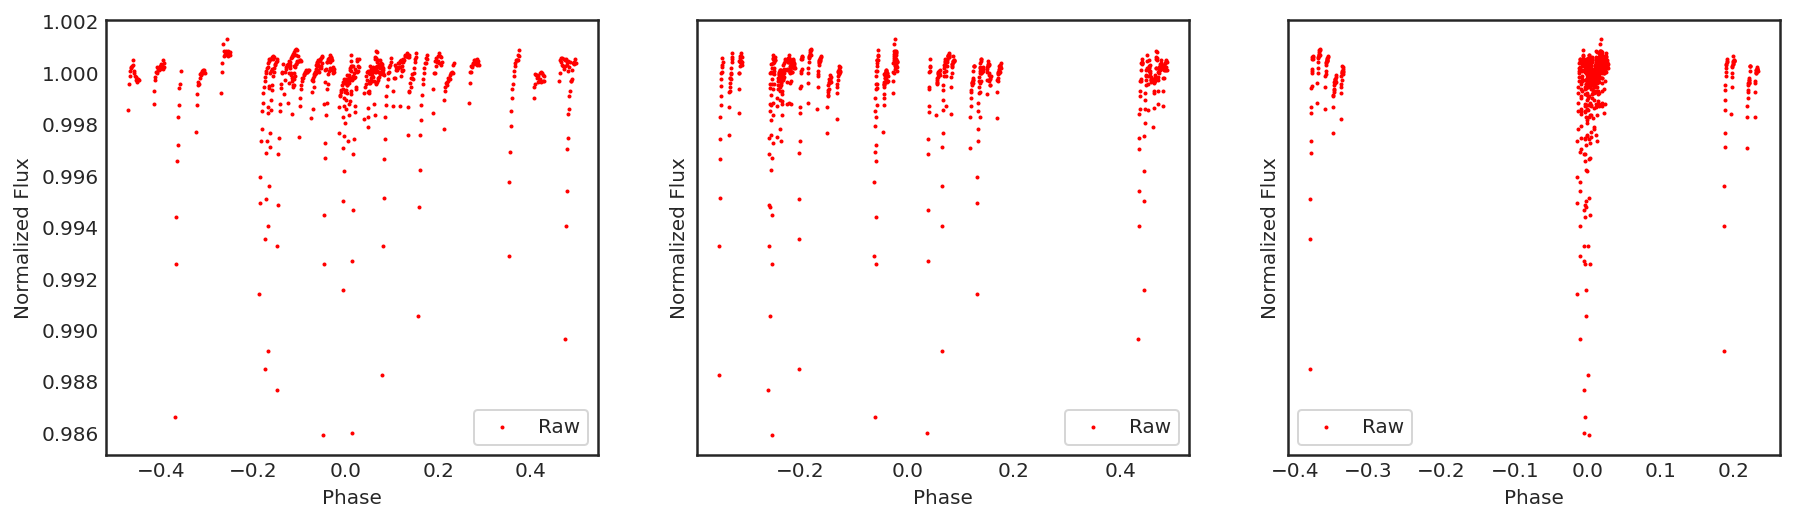

In [68]:
obs.plot()

In [76]:
obs.fit_transit(x_suppl=clc.time.value,
                y_suppl=clc.flux.value,
                yerr_suppl=clc.flux_err.value * 0.2,
                exptime_suppl=np.median(np.diff(clc.time.value)), fit_t0=False, fit_period=False, fit_inc=True, calc_eclipse=False, ttvs=True)

optimizing logp for variables: [u_suppl, r_suppl, inc, r_star, m_star, u, r]


message: Desired error not necessarily achieved due to precision loss.
logp: -1.0987547210619814e+18 -> -1.085337712795773e+18
optimizing logp for variables: [r_suppl, tts_d, tts_c, tts_b, inc, r, m_star, r_star, u, u_suppl, y_supplmean]


message: Desired error not necessarily achieved due to precision loss.
logp: -1.085337712795773e+18 -> -1.0493408410761061e+18


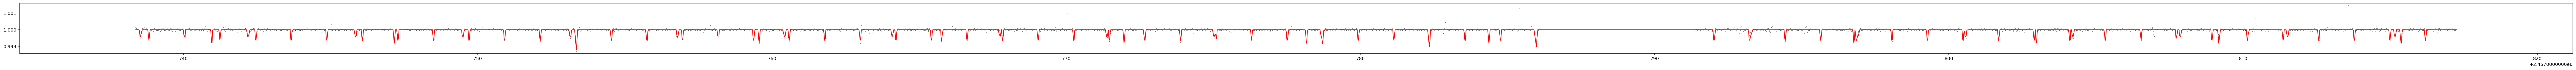

In [77]:
plt.figure(figsize=(100, 2))
plt.scatter(clc.time.value, clc.flux.value, s=0.1, c='k')
plt.plot(clc.time.value, obs.map_soln['transit_suppl'] + 1, c='r')

array([<AxesSubplot:title={'center':'Planet b'}, xlabel='Phase', ylabel='Normalized Flux'>,
       <AxesSubplot:title={'center':'Planet c'}, xlabel='Phase', ylabel='Normalized Flux'>,
       <AxesSubplot:title={'center':'Planet d'}, xlabel='Phase', ylabel='Normalized Flux'>],
      dtype=object)

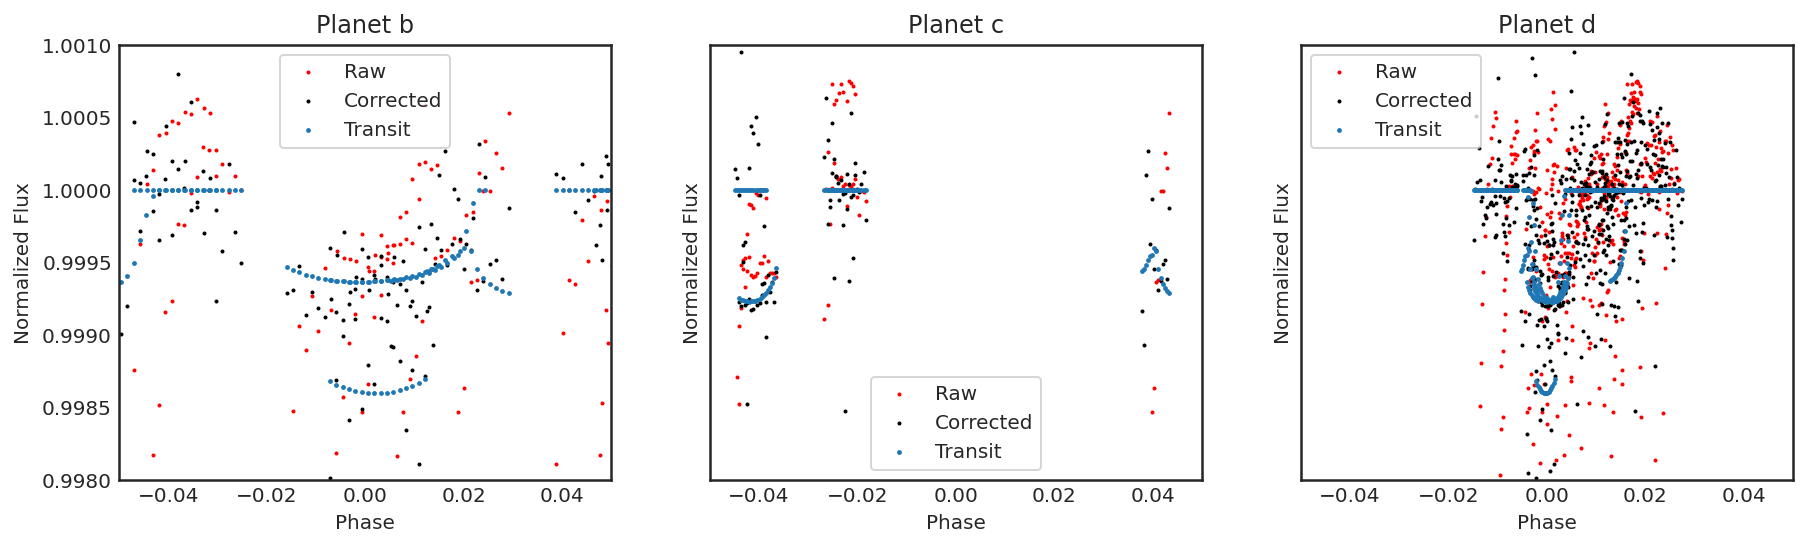

In [78]:
obs.plot(xlim=(-0.05, 0.05), ylim=(0.998, 1.001))

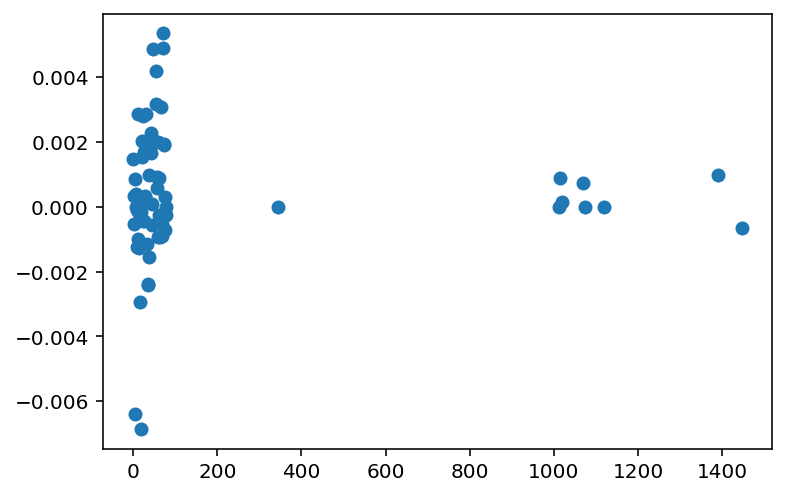

In [82]:
orig_t0s = pmx.eval_in_model(obs._pymc3_model.tts_b, model=obs._pymc3_model, point=obs._pymc3_model.test_point)
plt.scatter(orig_t0s, orig_t0s - obs.map_soln['tts_b'])

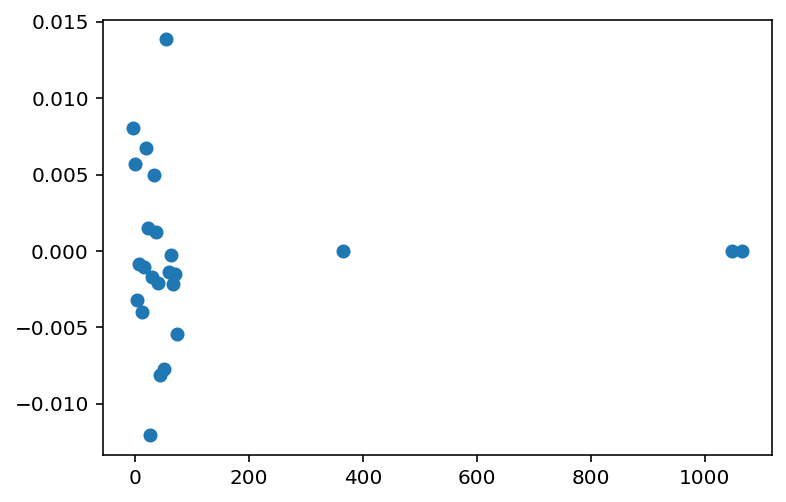

In [83]:
orig_t0s = pmx.eval_in_model(obs._pymc3_model.tts_c, model=obs._pymc3_model, point=obs._pymc3_model.test_point)
plt.scatter(orig_t0s, orig_t0s - obs.map_soln['tts_c'])

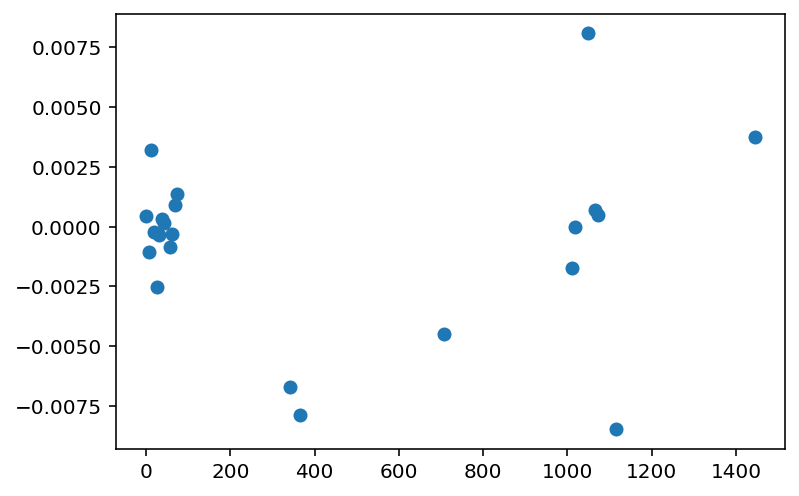

In [84]:
orig_t0s = pmx.eval_in_model(obs._pymc3_model.tts_d, model=obs._pymc3_model, point=obs._pymc3_model.test_point)
plt.scatter(orig_t0s, orig_t0s - obs.map_soln['tts_d'])

/Users/ch/HST/projects/ombre/src/ombre/visit.py:700: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots()


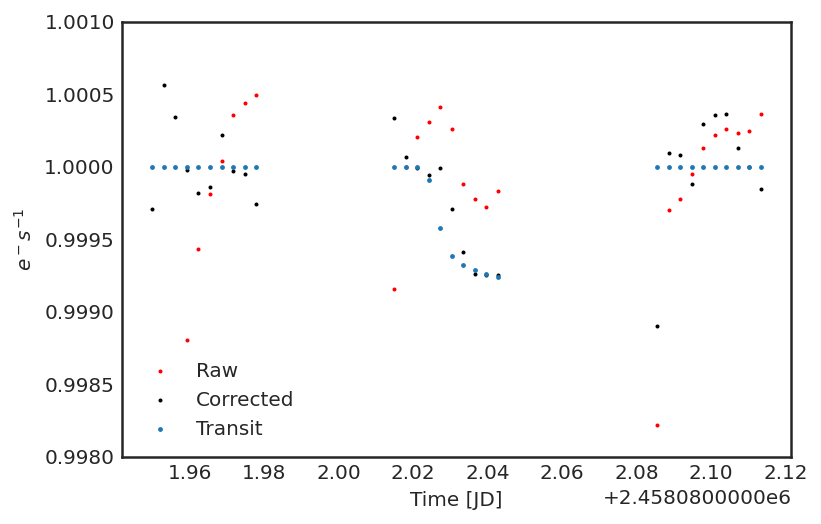

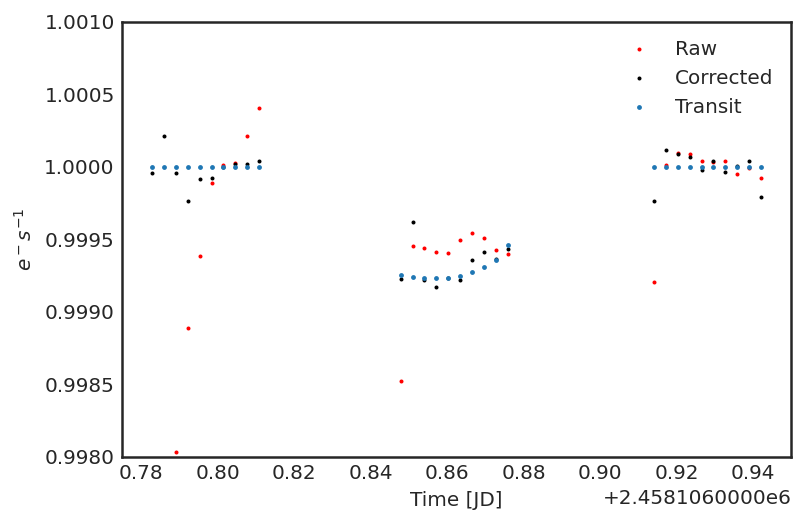

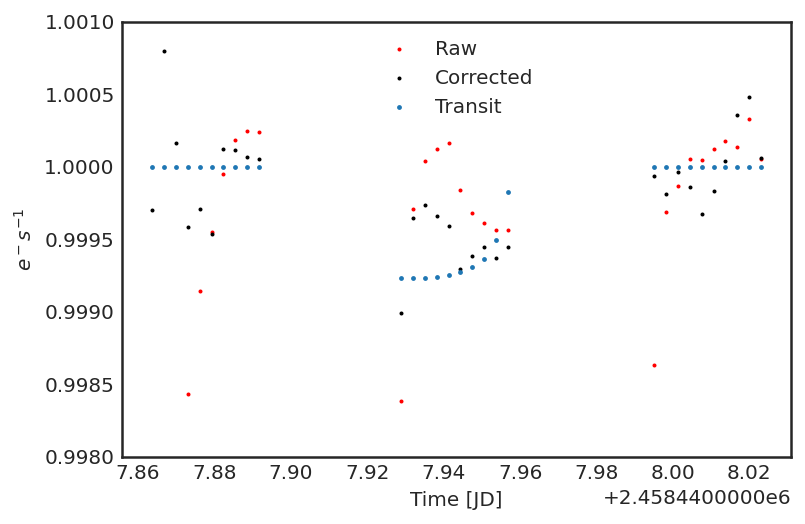

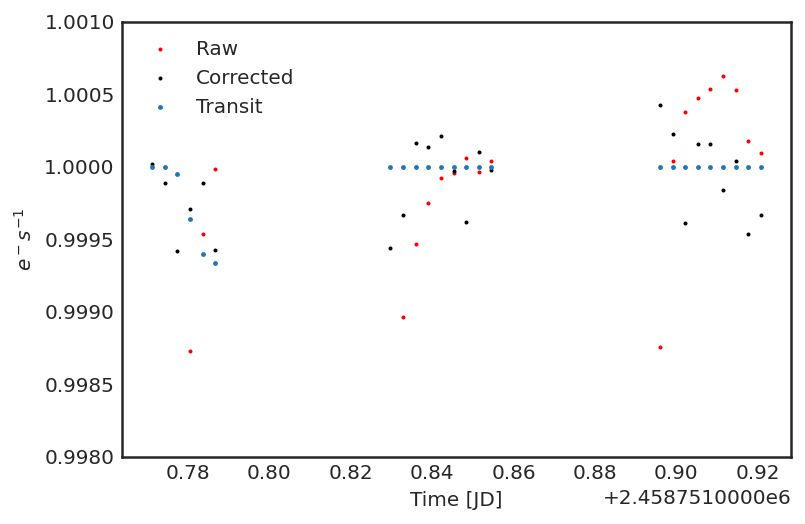

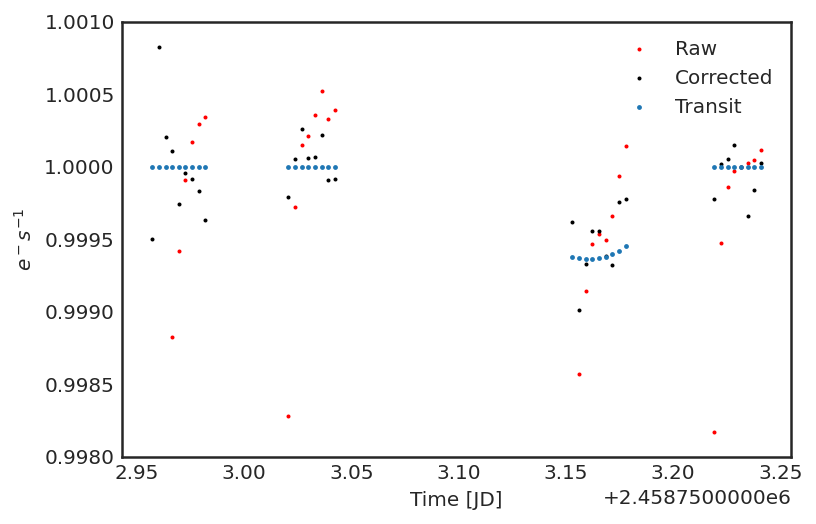

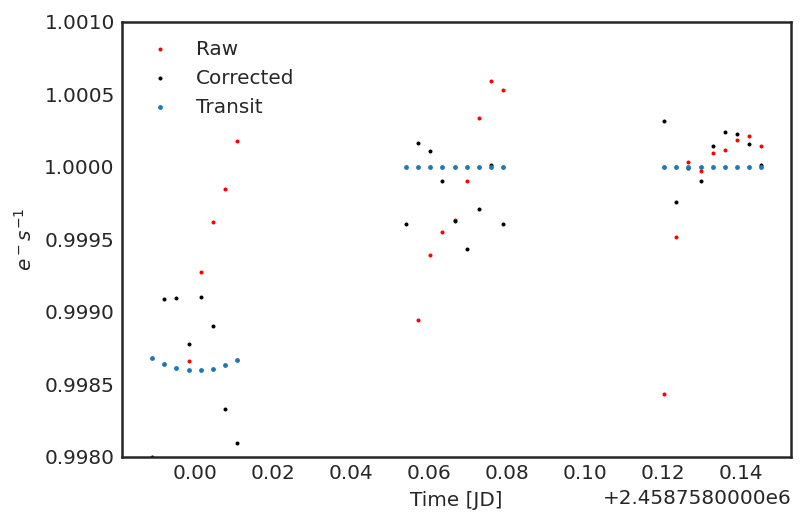

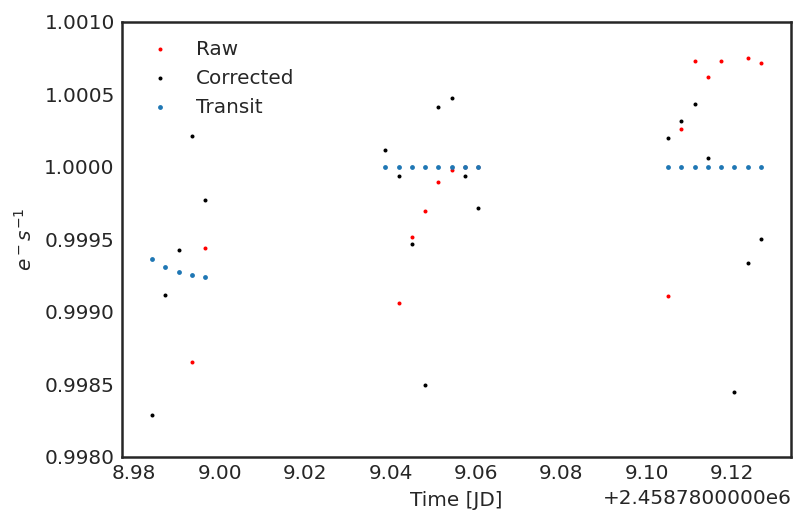

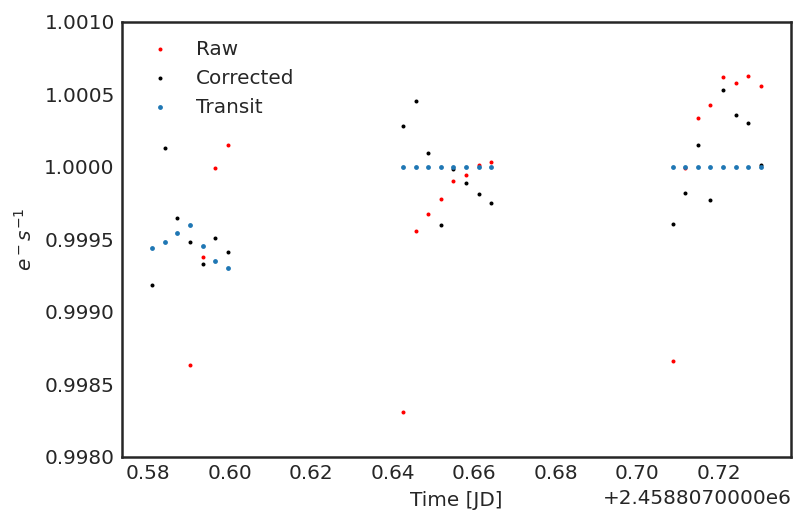

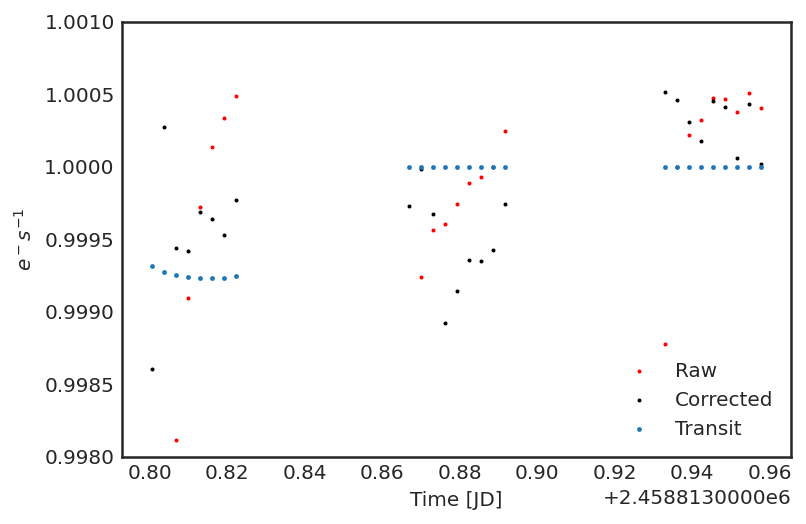

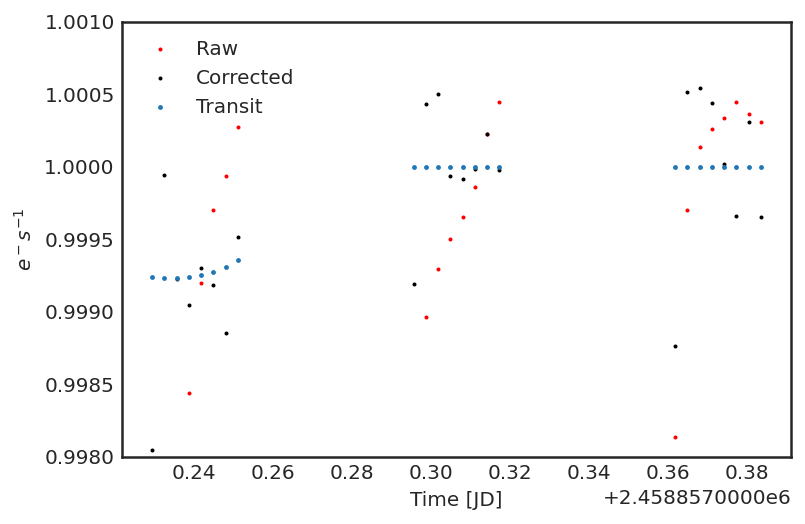

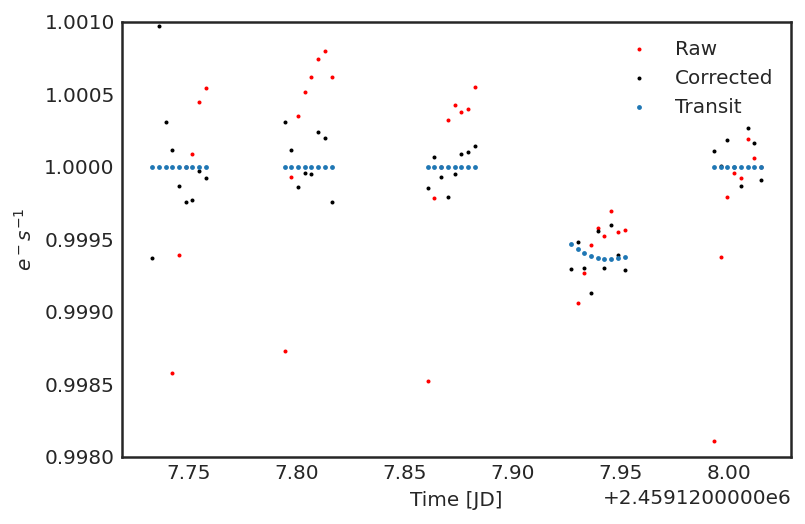

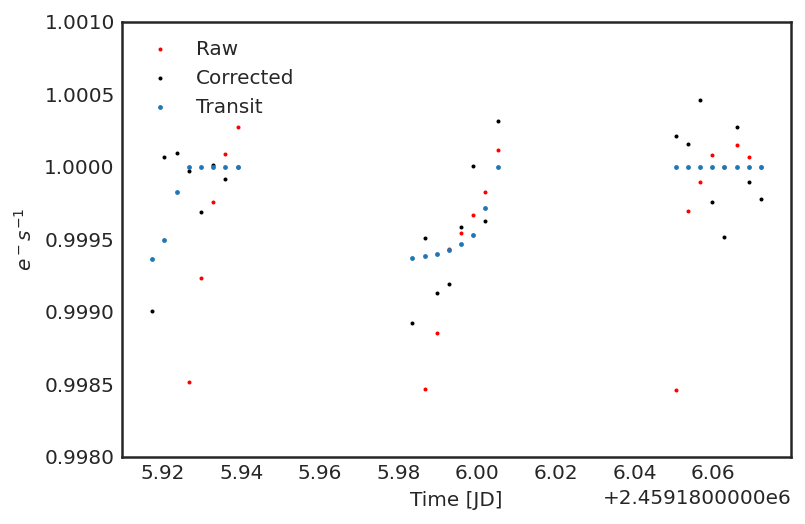

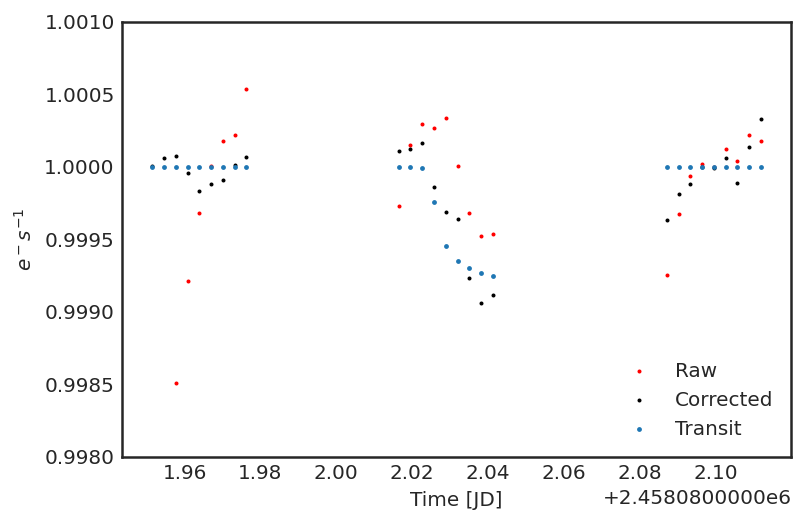

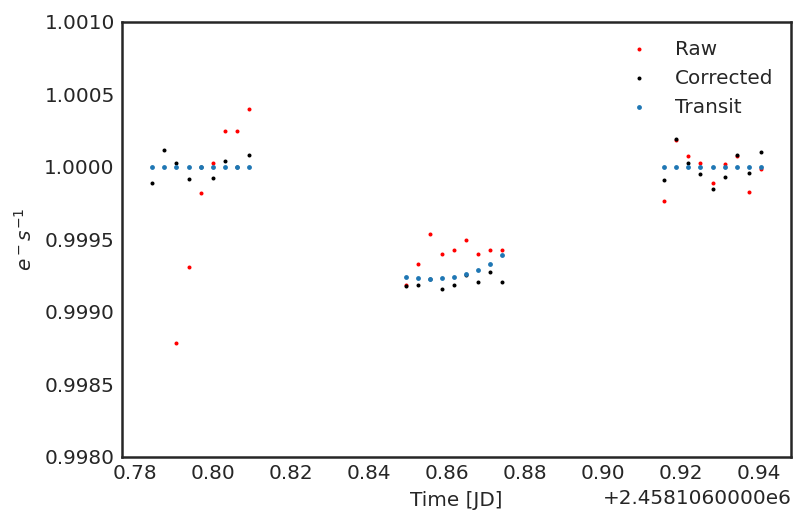

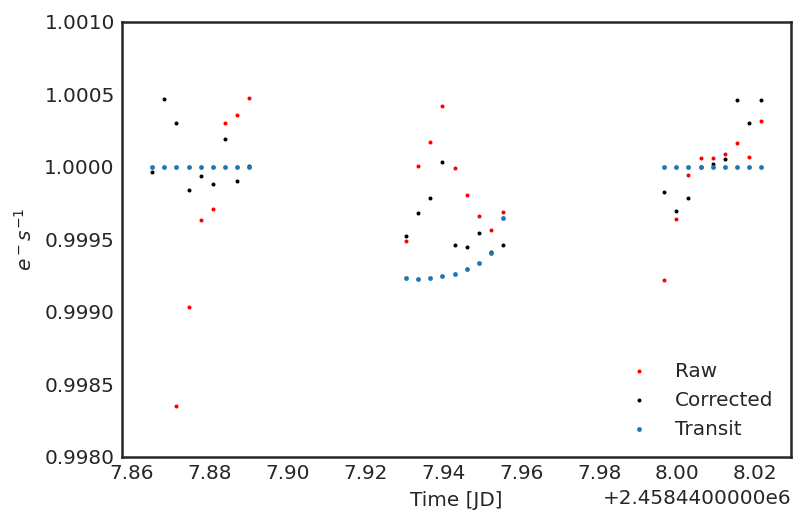

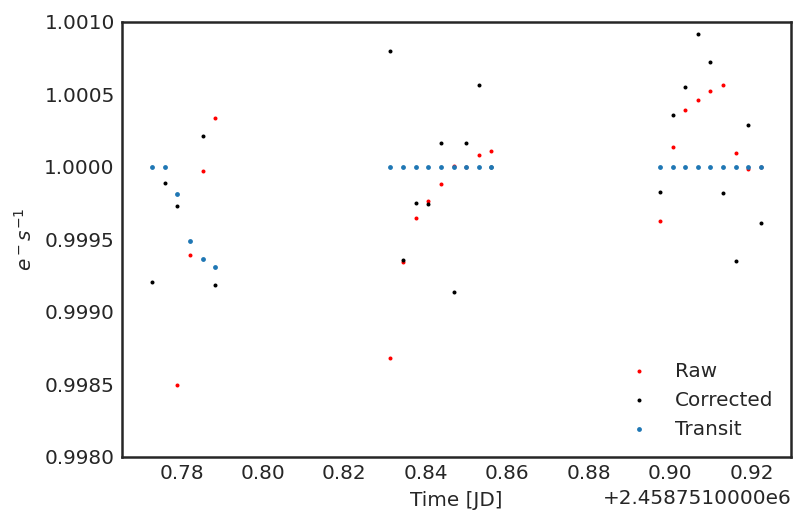

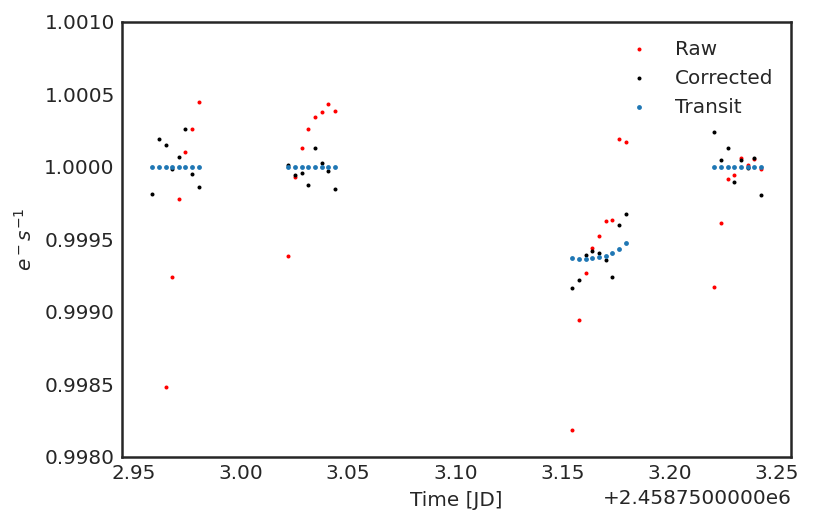

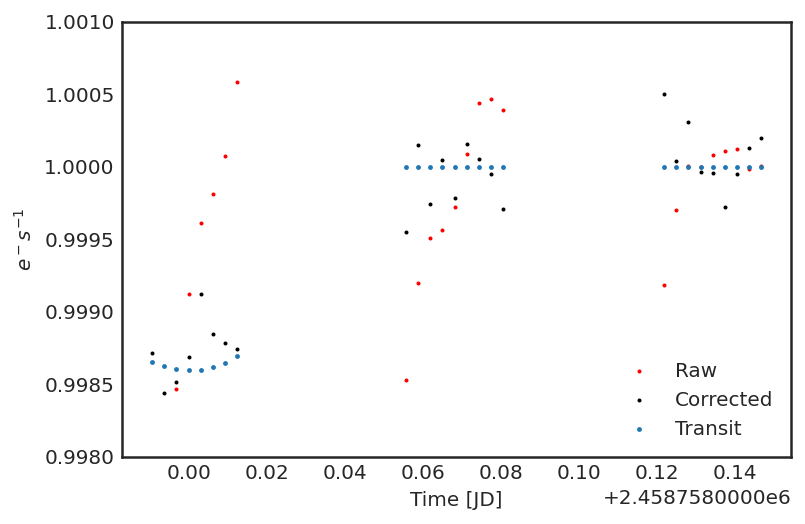

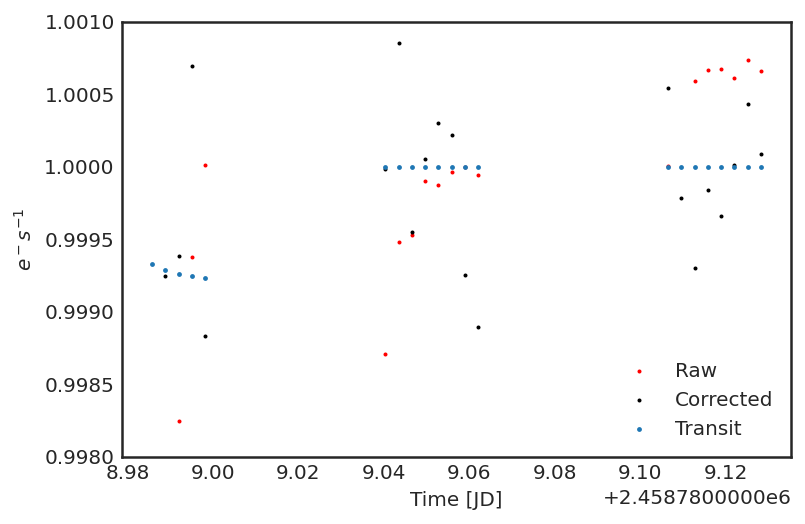

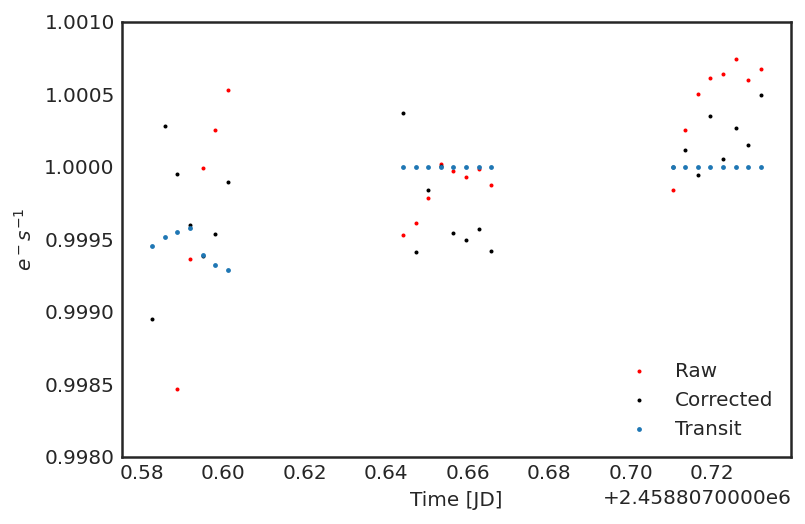

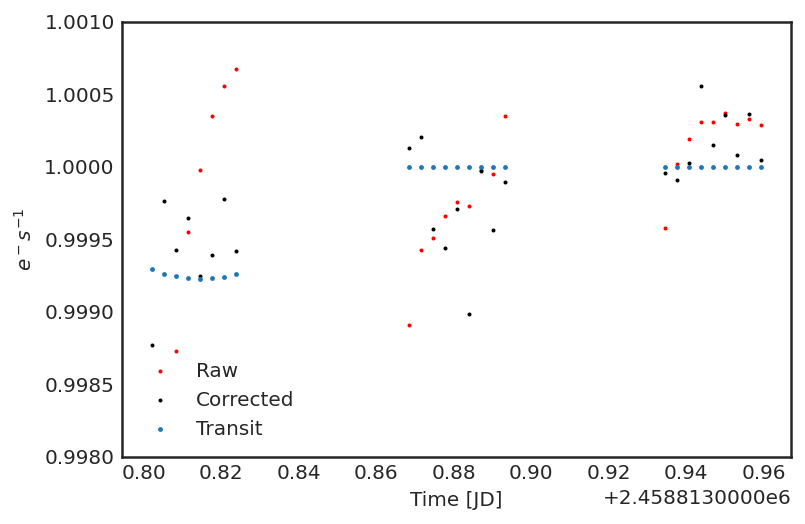

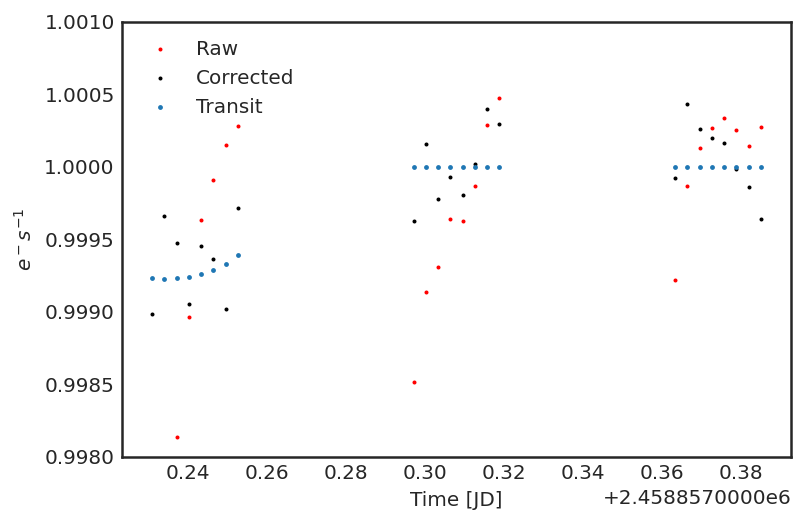

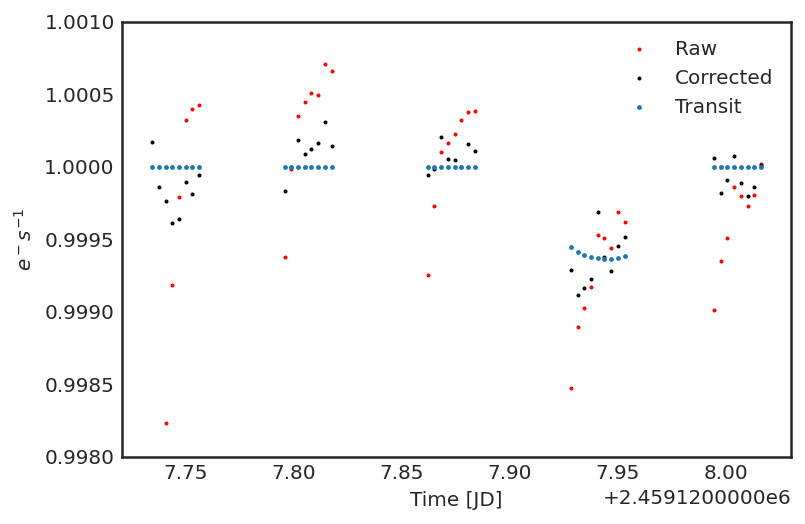

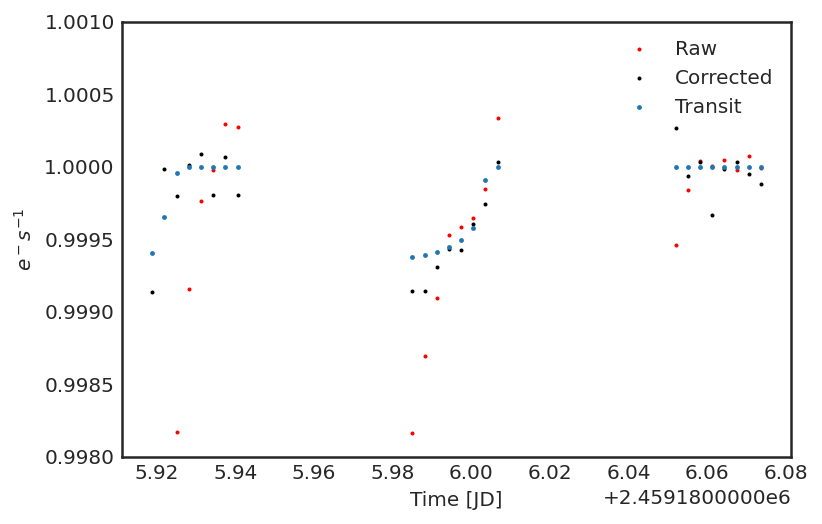

In [85]:
for visit in obs:
    visit.plot(ylim=(0.998, 1.001))

array([<AxesSubplot:title={'center':'Planet b'}, xlabel='Phase', ylabel='Normalized Flux'>,
       <AxesSubplot:title={'center':'Planet c'}, xlabel='Phase', ylabel='Normalized Flux'>,
       <AxesSubplot:title={'center':'Planet d'}, xlabel='Phase', ylabel='Normalized Flux'>],
      dtype=object)

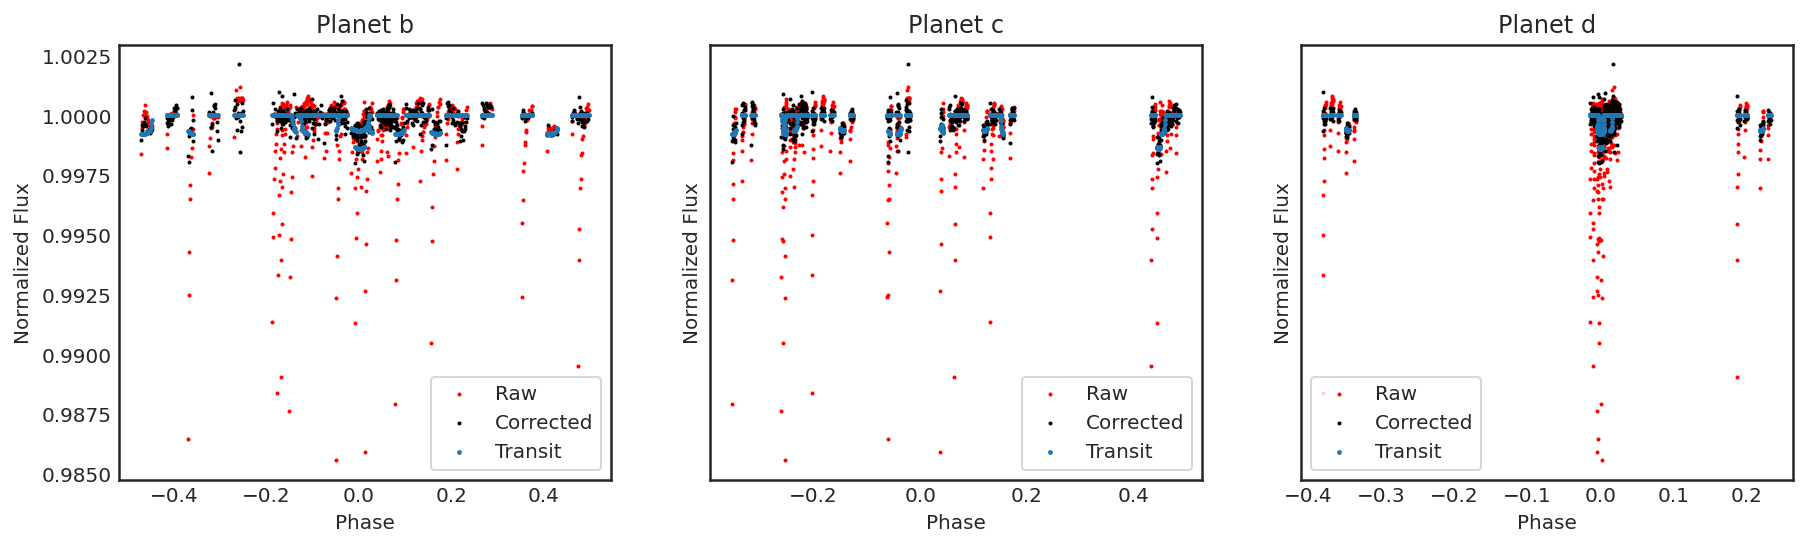

In [87]:
obs.plot()

In [90]:
obs.fit_model()

Fitting Transit/Eclipse Model: 100%|█████████████████████████████████████████| 24/24 [11:51<00:00, 29.65s/it]


In [91]:
obs.map_soln['r']

array([0.01445673, 0.01137735, 0.01851468])

In [92]:
obs.map_soln['r_suppl']

array([0.01460278, 0.01154027, 0.01923417])

In [93]:
#obs.plot_spectra()

<AxesSubplot:title={'center':'GJ-9827b Transmission Spectrum, Visit: 0'}, xlabel='Wavelength', ylabel='$\\delta$ Transit Depth [ppm]'>

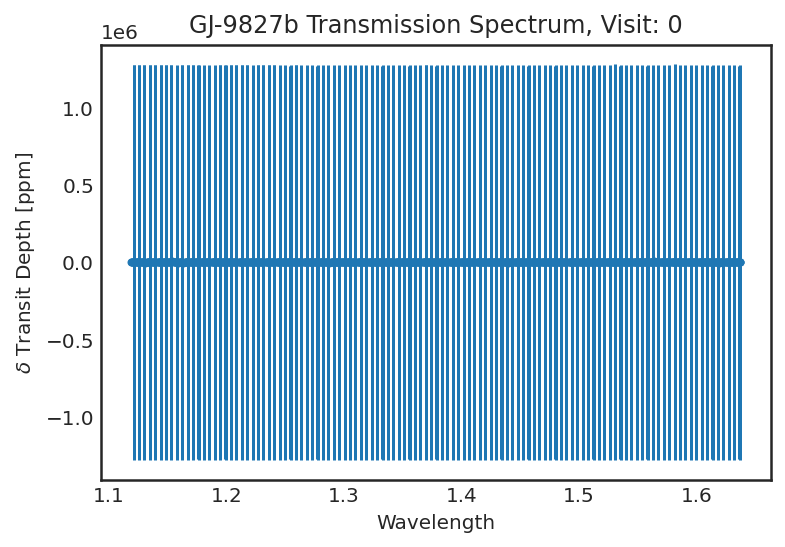

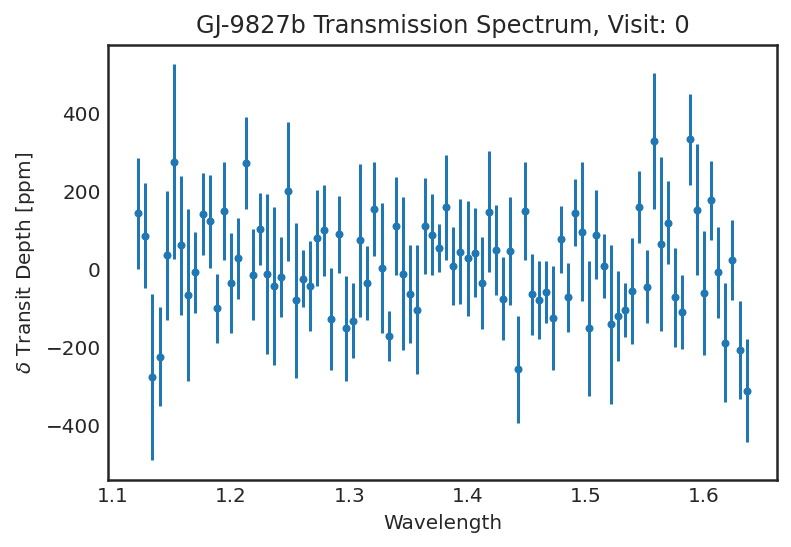

In [94]:
spec_b = om.Spectra([visit.transmission_spectrum['b'] for visit in obs if visit.transmission_spectrum['b'].spec.sum() != 0]).flatten()
spec_b.plot(ls='', marker='.')
spec_b.bin(np.linspace(1.1, 1.7, 100)).plot(ls='', marker='.')

/Users/ch/HST/projects/ombre/src/ombre/spec.py:165: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots()


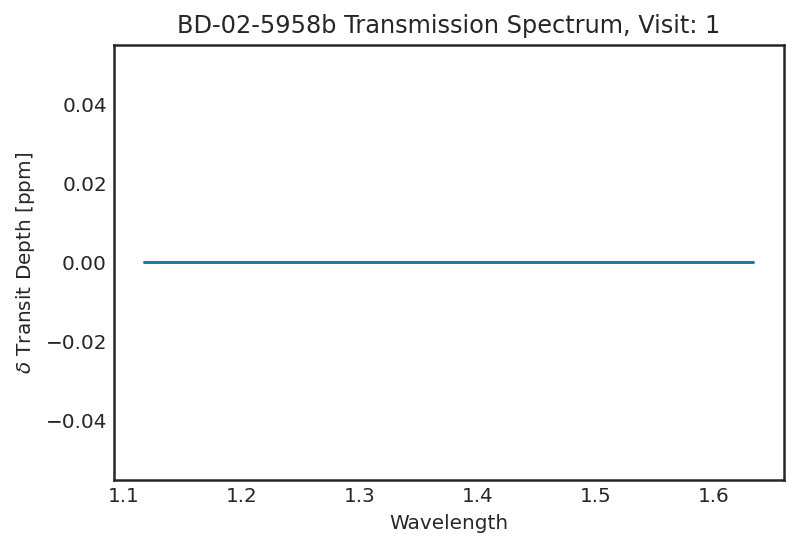

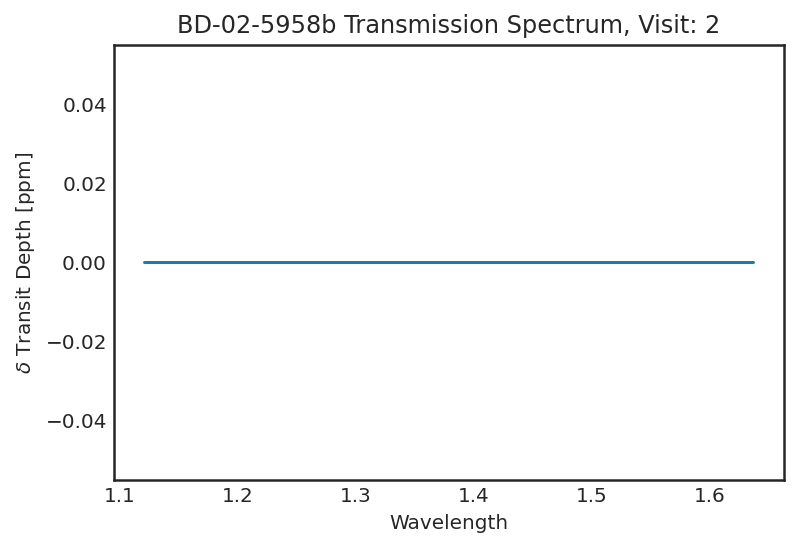

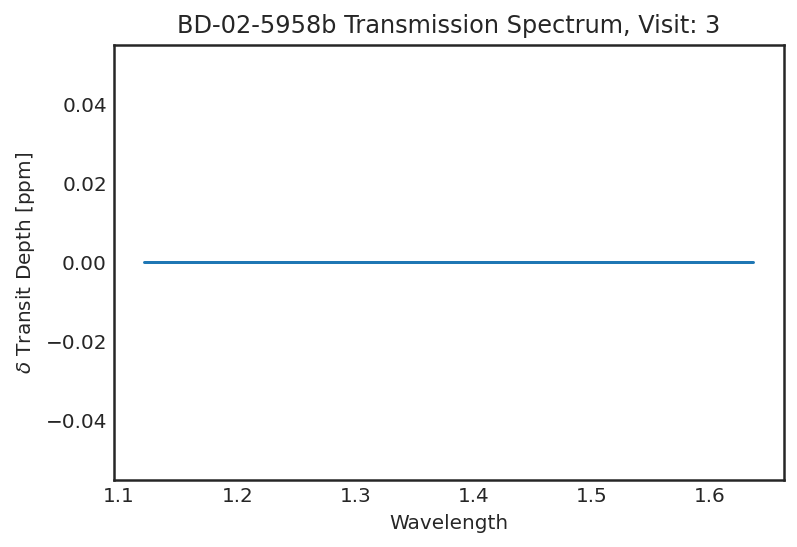

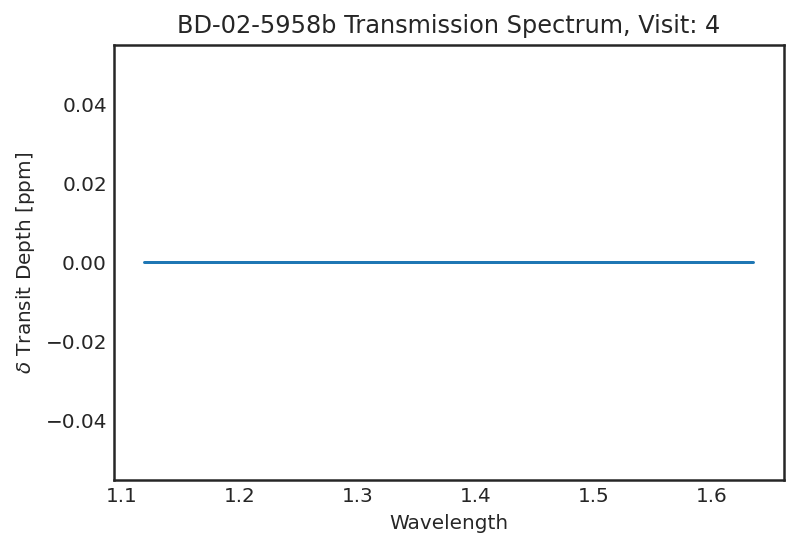

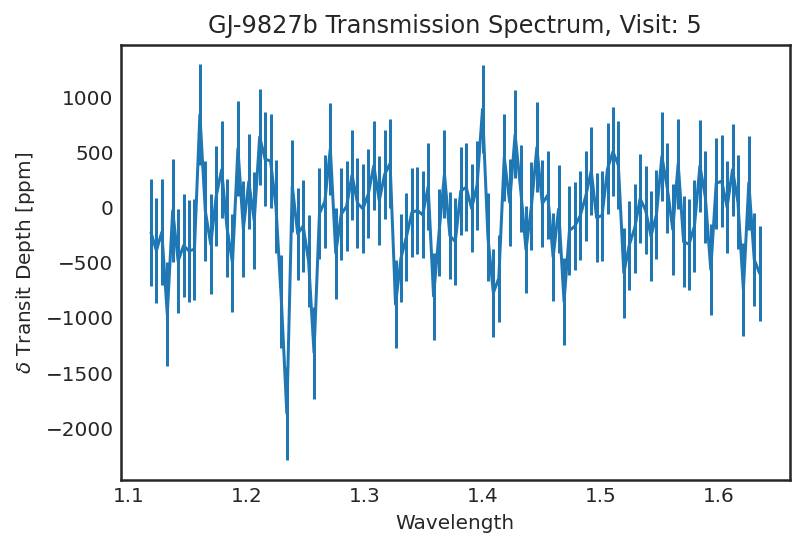

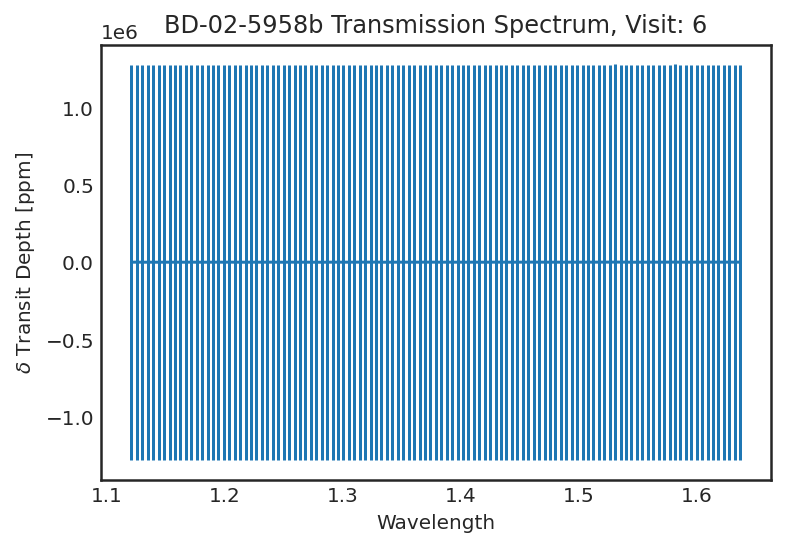

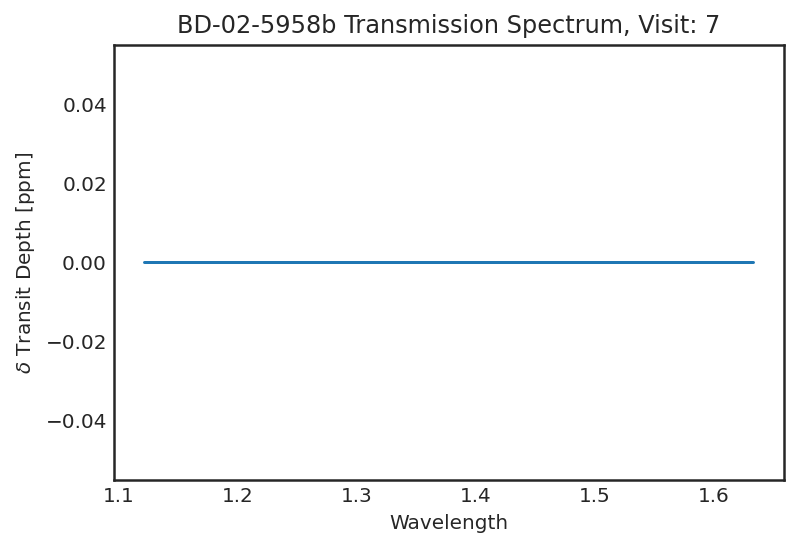

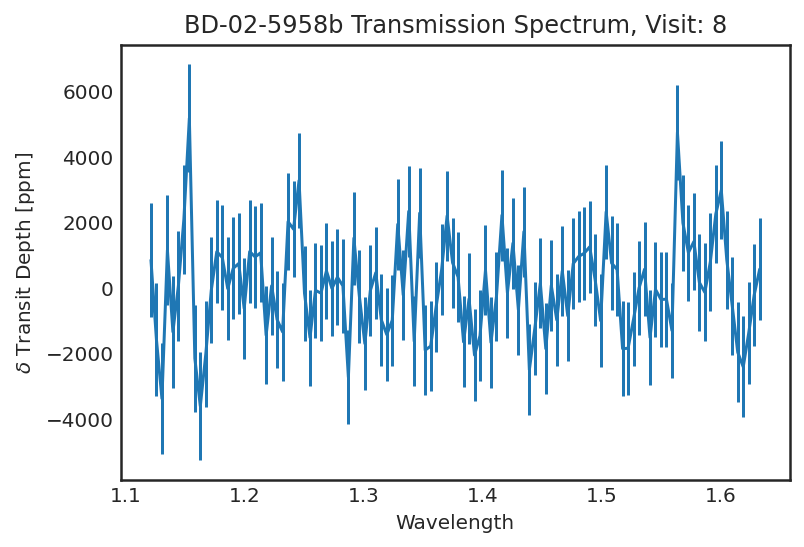

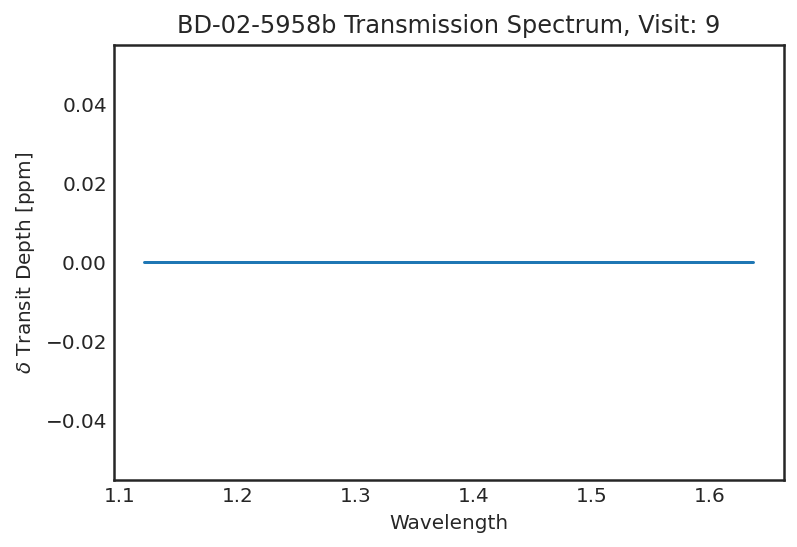

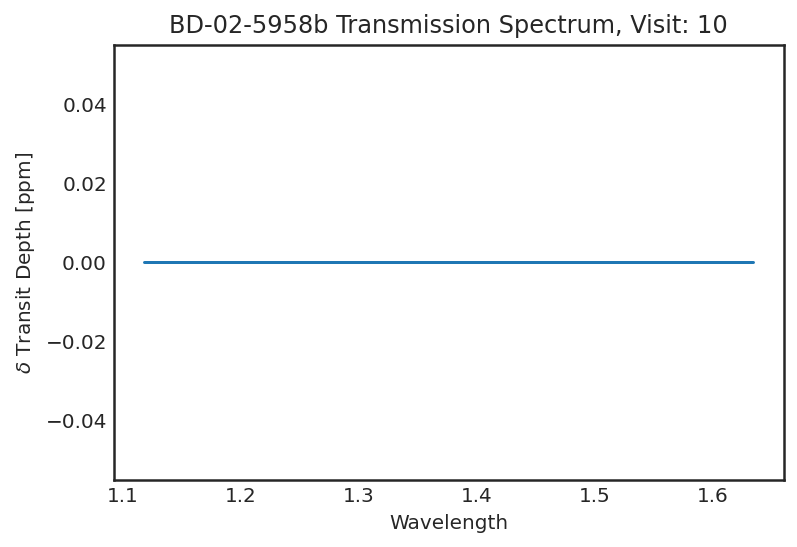

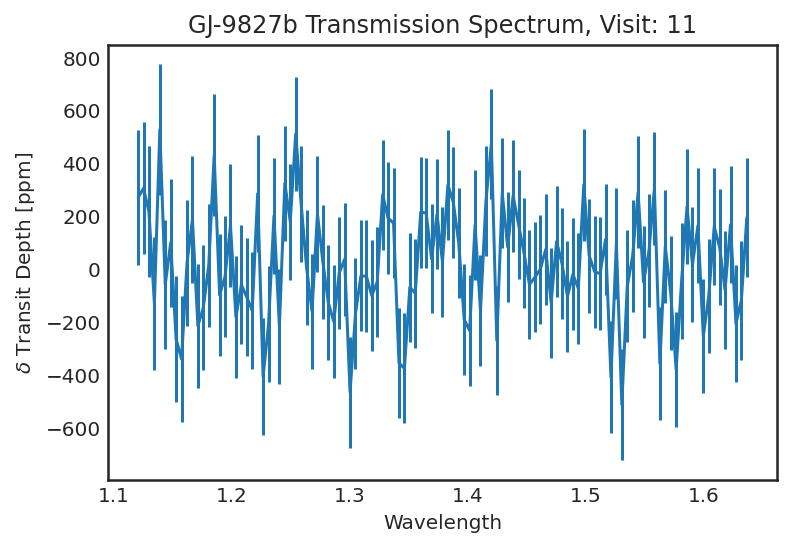

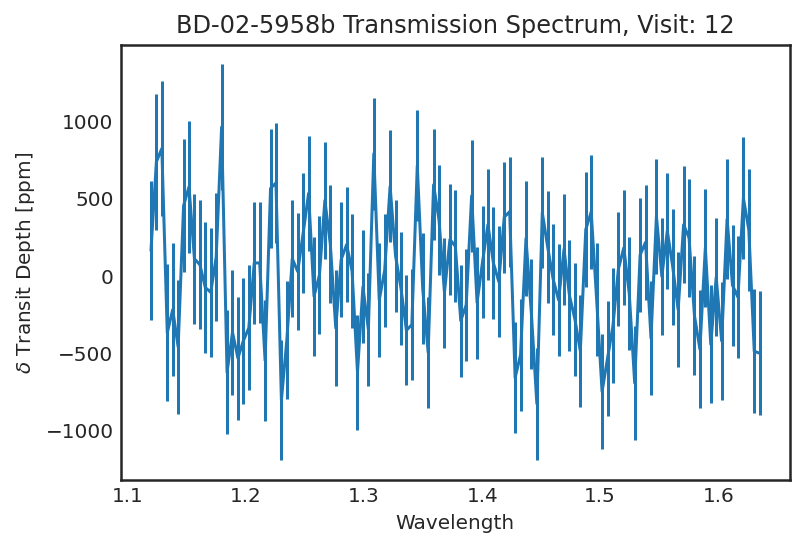

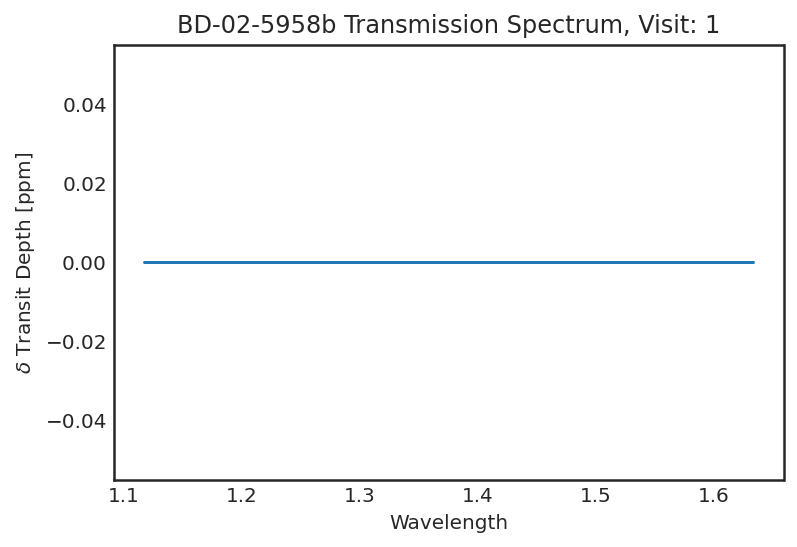

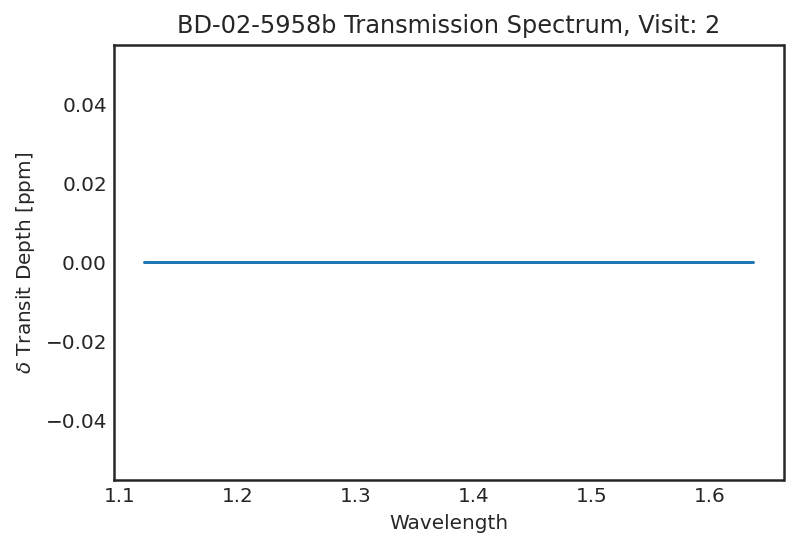

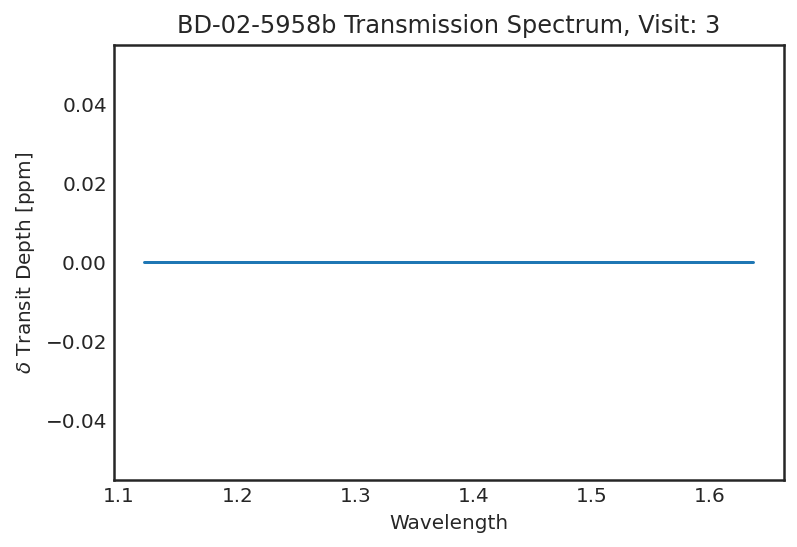

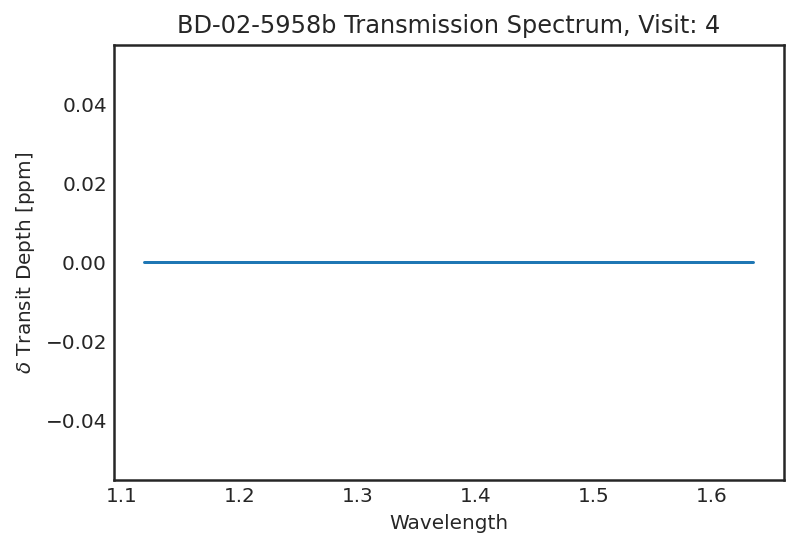

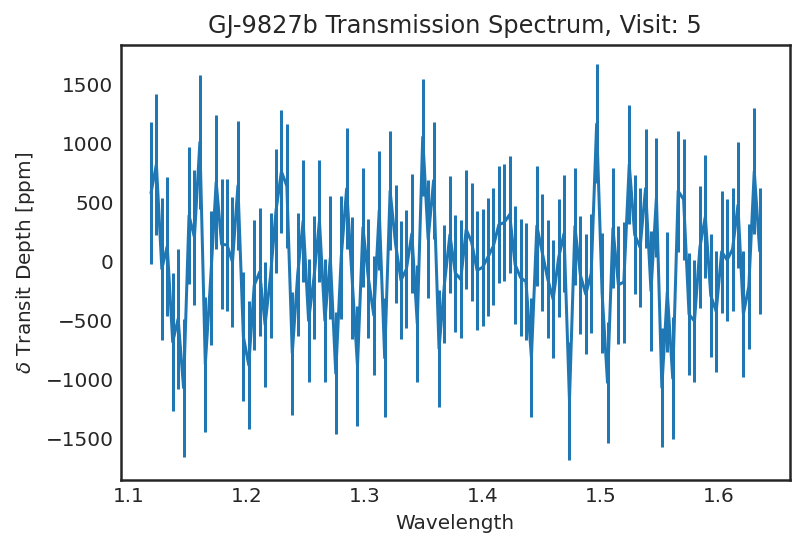

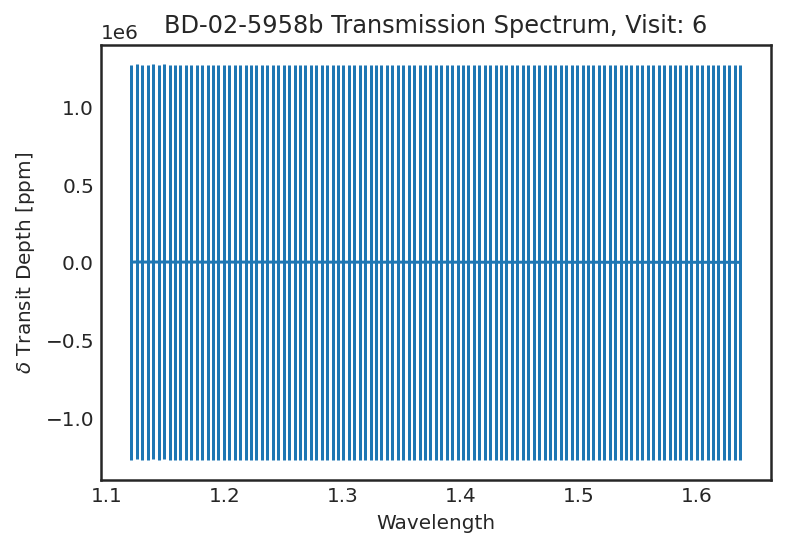

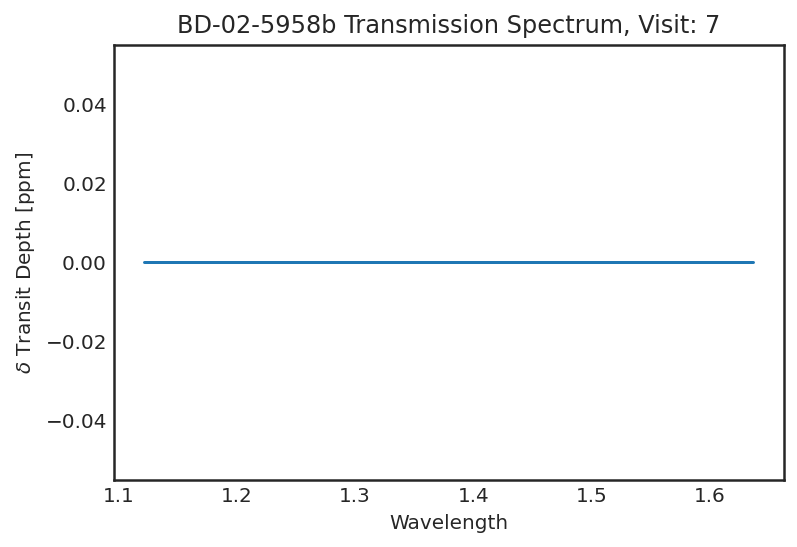

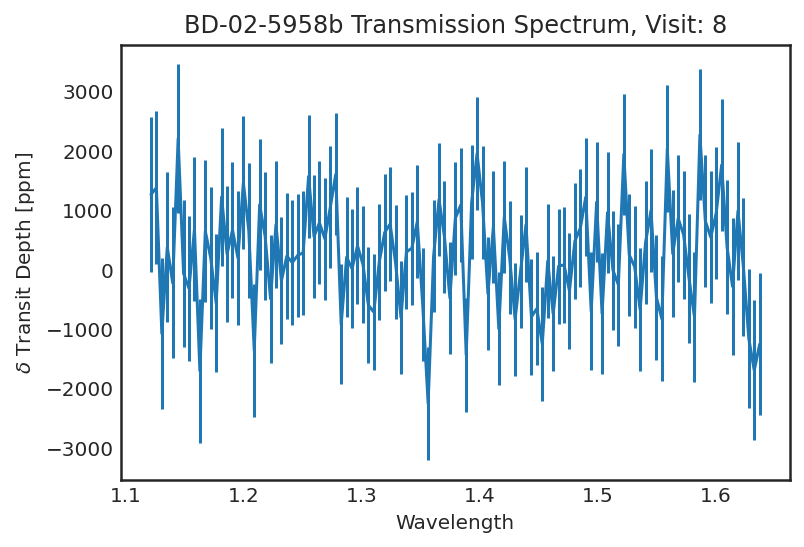

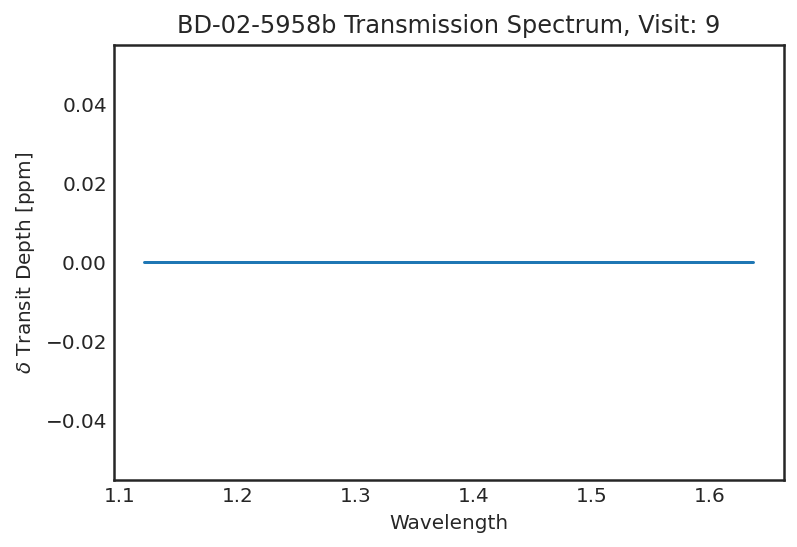

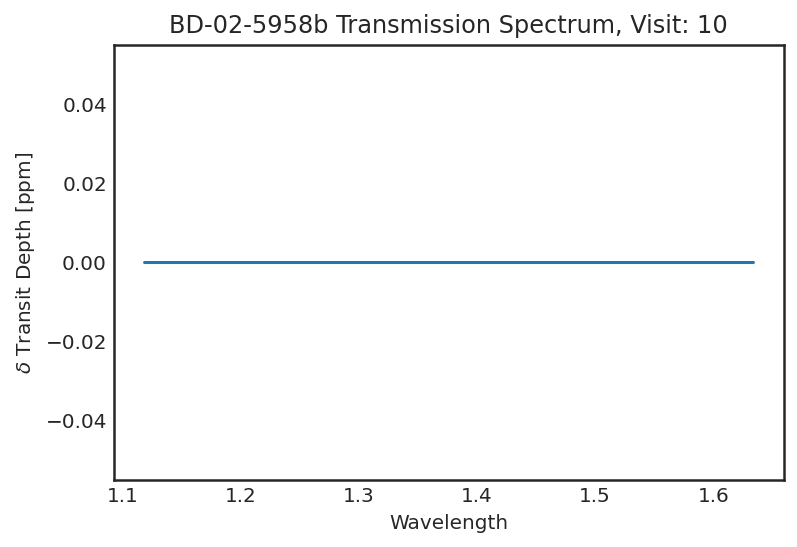

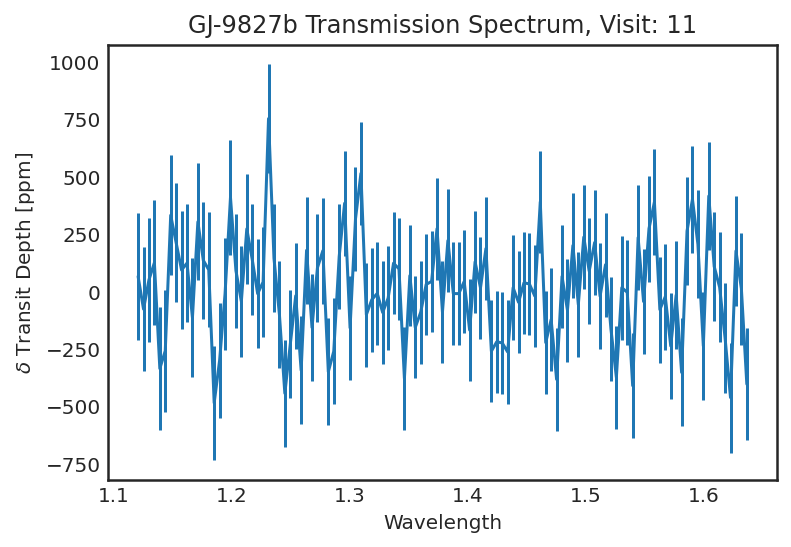

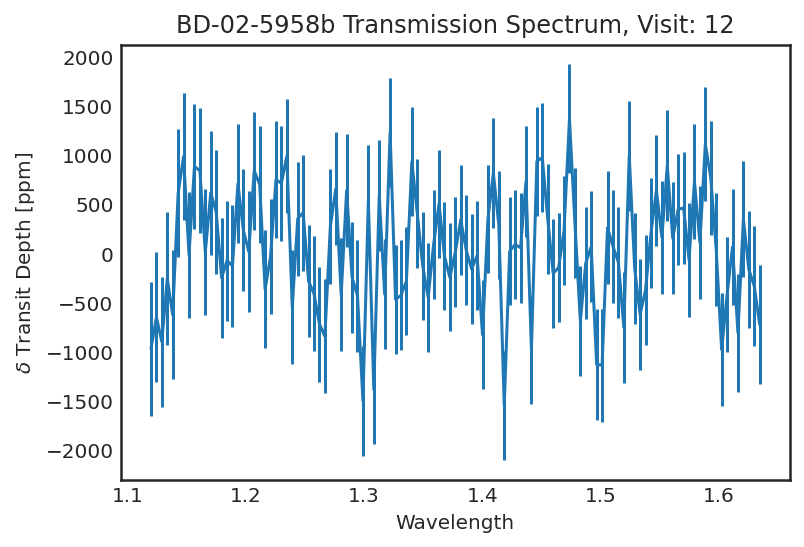

In [123]:
for visit in obs:
    visit.transmission_spectrum['b'].plot()

<AxesSubplot:title={'center':'BD-02-5958d Transmission Spectrum, Visit: 0'}, xlabel='Wavelength', ylabel='$\\delta$ Transit Depth [ppm]'>

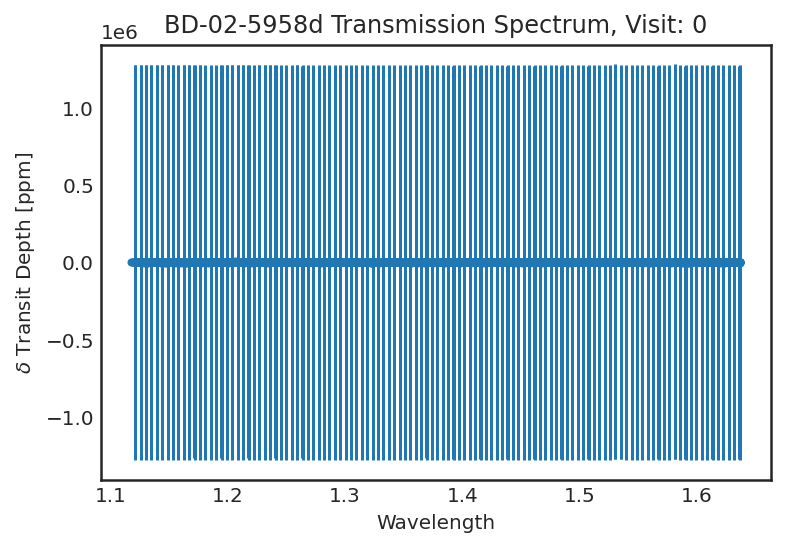

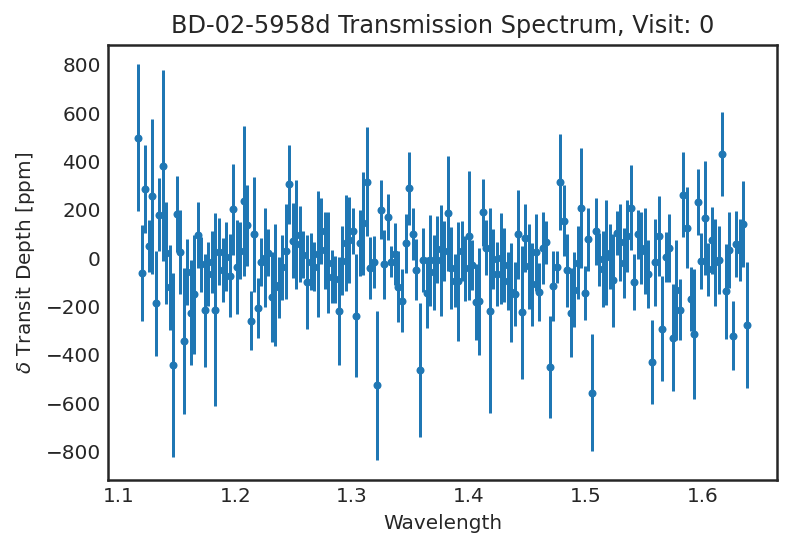

In [121]:
spec_d = om.Spectra([visit.transmission_spectrum['d'] for visit in obs if visit.transmission_spectrum['d'].spec.sum() != 0]).flatten()
spec_d.plot(ls='', marker='.')
spec_d.bin(np.linspace(1.1, 1.7, 200)).plot(ls='', marker='.')           

In [120]:
spec_d

Spectrum [Visit 0]

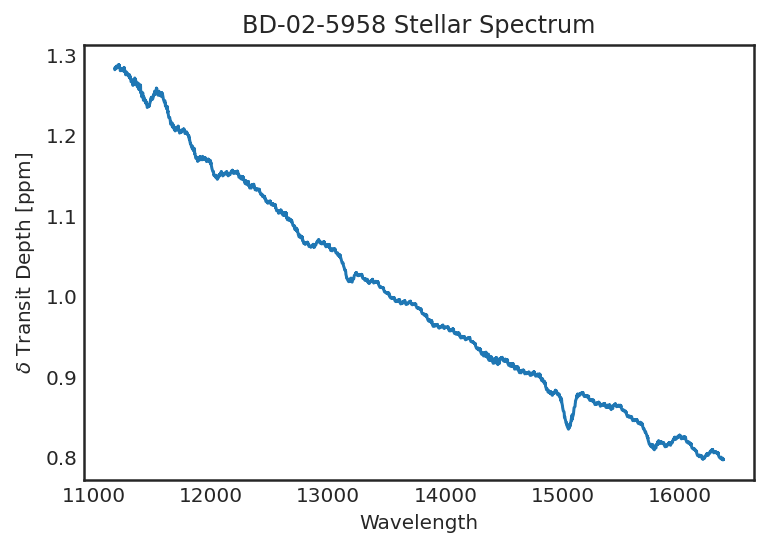

In [96]:
spec = obs.stellar_spectra
spec.plot()
spec.hdulist.writeto(f'results/GJ9827_stellar_spectrum.fits', overwrite=True)

In [97]:
# from astropy.io import fits
# try:
#     hdulist = om.Spectra([visit.transmission_spectrum for visit in obs if visit.transmission_spectrum.spec.sum() != 0]).hdulist
#     hdulist.writeto(f'results/{name}_transmission.fits')
# except:
#     pass
# try:    
#     hdulist = om.Spectra([visit.emission_spectrum for visit in obs if visit.emission_spectrum.spec.sum() != 0]).hdulist
#     hdulist.writeto(f'results/{name}_emission.fits')
# except:
#     pass

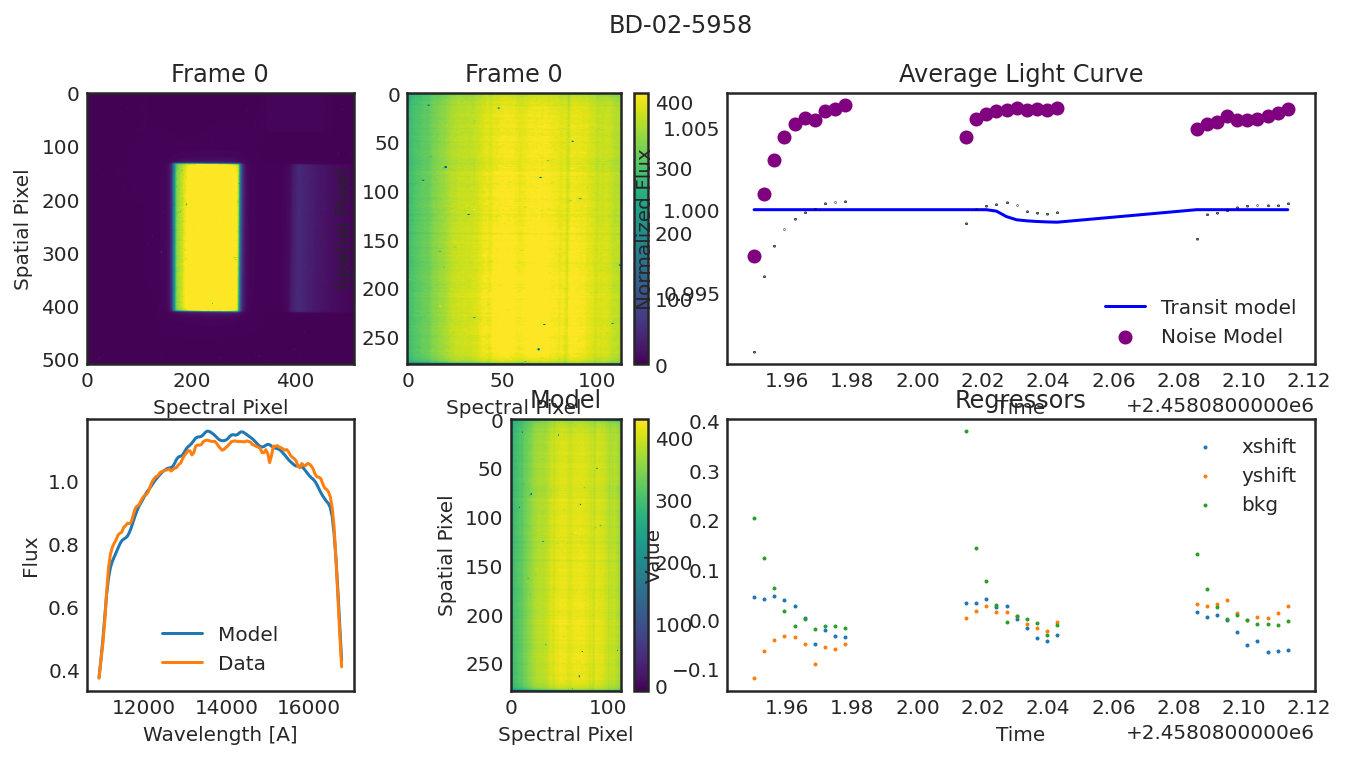

In [98]:
for visit in obs:
    visit.diagnose();
    plt.show();
    break

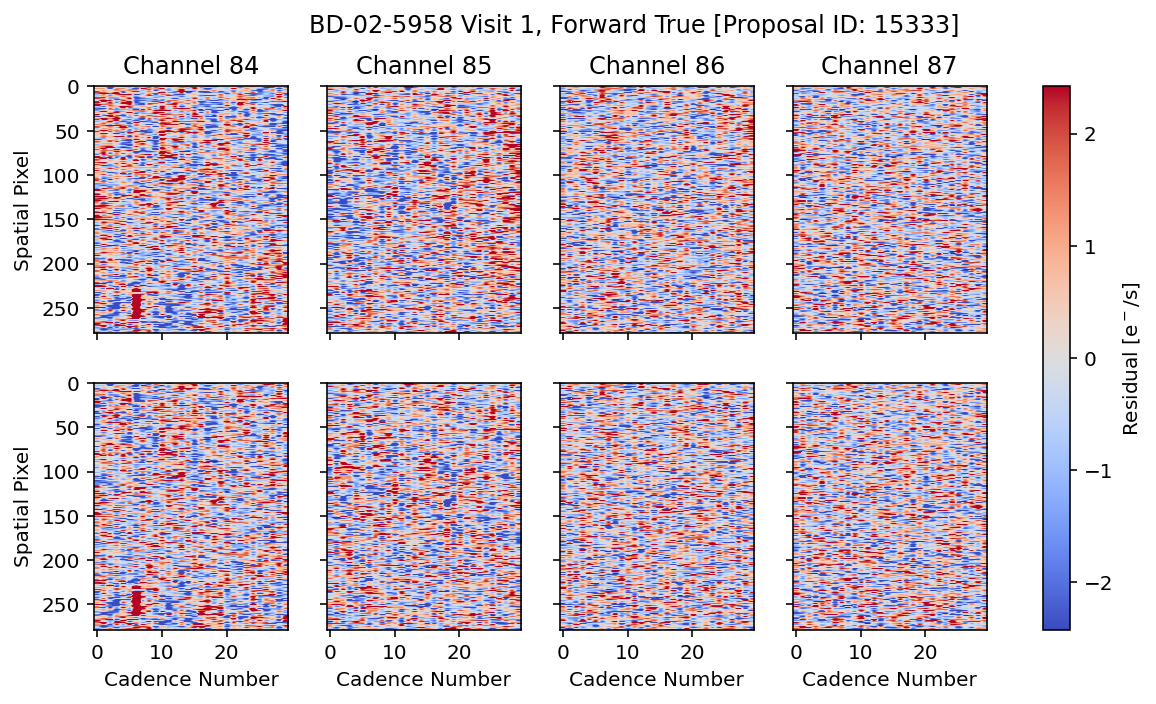

In [99]:
for visit in obs:
    visit.plot_residual_panel();
    plt.show();
    break